# FIPS References

This notebook provides insights into the references of FIPS certificates.

In [1]:
import sys
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt

from sec_certs.utils.plot_utils import (
    get_cert_property,
    get_fips_cert_references_graph,
    get_most_referenced_cert_graph,
    get_most_referencing_cert_graph,
)
from sec_certs.dataset.fips import FIPSDataset

from enum import Enum
from collections import Counter
from pprint import pprint

# Typing imports
from pandas.core.frame import DataFrame, Series

#%matplotlib inline
#matplotlib.use("pgf")
sns.set_theme(style='white')
plt.rcParams["axes.linewidth"] = 0.5
plt.rcParams["legend.fontsize"] = 6.5
plt.rcParams["xtick.labelsize"] = 8
plt.rcParams["ytick.labelsize"] = 8
plt.rcParams["ytick.left"] = True
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["ytick.major.pad"] = 0
plt.rcParams["xtick.bottom"] = True
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["xtick.major.pad"] = 0
# plt.rcParams["pgf.texsystem"] = "pdflatex"
plt.rcParams["font.family"] = "serif"
# plt.rcParams["text.usetex"] = True
# plt.rcParams["pgf.rcfonts"] = False
plt.rcParams["axes.titlesize"] = 10
plt.rcParams["legend.handletextpad"] = 0.3
plt.rcParams["lines.markersize"] = 4
plt.rcParams["savefig.pad_inches"] = 0.01
sns.set_palette("deep")

In [2]:
dset = FIPSDataset.from_web()

In [3]:
df = dset.to_pandas()

In [4]:
def get_references_count(references: set[str] | float) -> int:
    return 0 if pd.isna(references) else len(references)

In [5]:
df["outgoing_direct_references_count"] = df["module_directly_referencing"].apply(get_references_count)
df["incoming_direct_references_count"] = df["module_directly_referenced_by"].apply(get_references_count)
df["outgoing_indirect_references_count"] = df["module_indirectly_referencing"].apply(get_references_count)
df["incoming_indirect_references_count"] = df["module_indirectly_referenced_by"].apply(get_references_count)

## Analysis of FIPS references

In [6]:
REFS_COLUMNS: list[str] = [
    "cert_id",
    "status",
    "standard",
    "type",
    "level",
    "embodiment",
    "year_from",
    "related_cves",
    "module_directly_referenced_by",
    "module_indirectly_referenced_by",
    "module_directly_referencing",
    "module_indirectly_referencing",
    "policy_directly_referenced_by",
    "policy_indirectly_referenced_by",
    "policy_directly_referencing",
    "policy_indirectly_referencing",
    "outgoing_direct_references_count",
    "incoming_direct_references_count",
    "outgoing_indirect_references_count",
    "incoming_indirect_references_count"
]
df = df[REFS_COLUMNS]

### References EDA

#### Direct module references

In [7]:
n_certs: int = df.shape[0]
n_referencing_certs: int = df[df["outgoing_direct_references_count"] > 0].shape[0]
ratio: float = round(n_referencing_certs / n_certs, 2)

print(f"Total ratio of referencing certs in dataset: {ratio}")

Total ratio of referencing certs in dataset: 0.1


In [8]:
df[df["outgoing_direct_references_count"] > 0]["outgoing_direct_references_count"].describe()

count    477.000000
mean       1.322851
std        0.799528
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        8.000000
Name: outgoing_direct_references_count, dtype: float64

#### Indirect module references

In [9]:
df[df["outgoing_indirect_references_count"] > 0]["outgoing_indirect_references_count"].describe()

count    477.000000
mean       2.207547
std        2.923554
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       27.000000
Name: outgoing_indirect_references_count, dtype: float64

#### Direct references per status

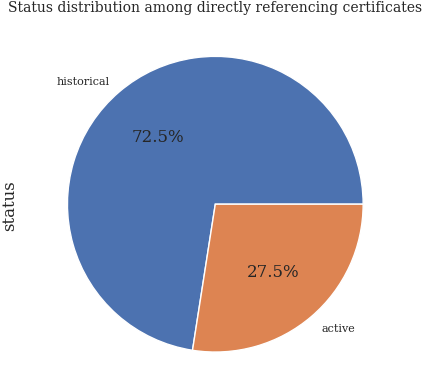

In [10]:
refs_direct_eda_df: DataFrame = df[df["outgoing_direct_references_count"] > 0]
refs_direct_eda_df["status"].value_counts().loc[lambda x: x > 0].plot.pie(autopct="%.1f%%")

plt.title("Status distribution among directly referencing certificates")
plt.show()

#### Direct references per type


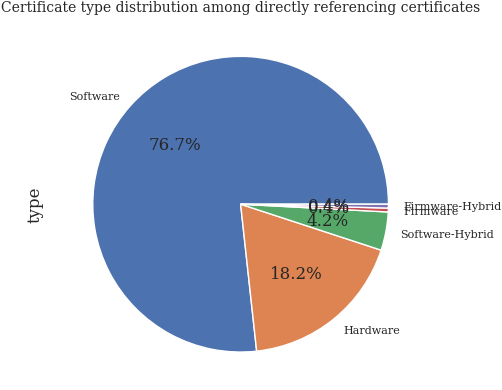

In [11]:
refs_direct_eda_df["type"].value_counts().loc[lambda x: x > 0].plot.pie(autopct="%.1f%%")

plt.title("Certificate type distribution among directly referencing certificates")
plt.show()

#### Direct references per level

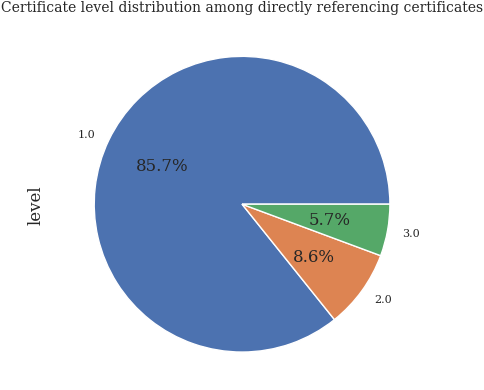

In [12]:
refs_direct_eda_df["level"].value_counts().loc[lambda x: x > 0].plot.pie(autopct="%.1f%%")

plt.title("Certificate level distribution among directly referencing certificates")
plt.show()

#### Direct references per embodiment

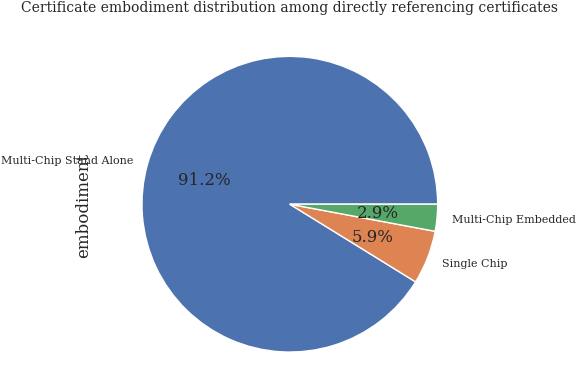

In [13]:
embodiment_counts_df = refs_direct_eda_df["embodiment"].value_counts().loc[lambda x: x > 0].plot.pie(autopct="%.1f%%")

plt.title("Certificate embodiment distribution among directly referencing certificates")
plt.show()

#### Time analysis of mean of references per years

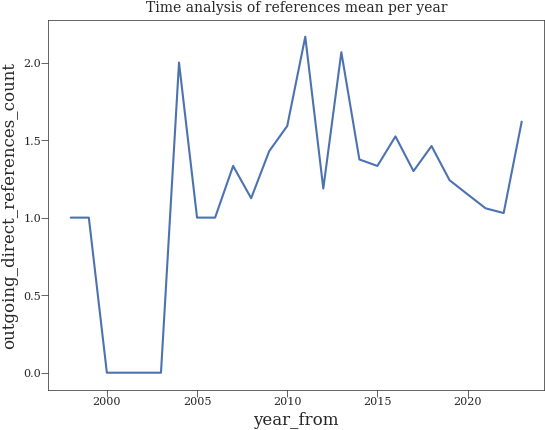

In [14]:
referencing_df = df[df["outgoing_direct_references_count"] > 0][
    ["year_from", "outgoing_direct_references_count"]
]
refs_grouped_by = referencing_df.select_dtypes(include=["number"]).groupby(["year_from"]).mean()
refs_grouped_by = refs_grouped_by.reset_index()

# Fill missing years
dataset_years: set[int] = set(refs_grouped_by["year_from"])
years_interval: set[int] = set(range(min(dataset_years), max(dataset_years) + 1))
missing_years: set[int] = years_interval - dataset_years

for year in missing_years:
    refs_grouped_by.loc[len(refs_grouped_by.index)] = (year, 0)

line = sns.lineplot(data=refs_grouped_by, x="year_from", y="outgoing_direct_references_count")

plt.title("Time analysis of references mean per year")
plt.show()

#### Distribution of total number of references per cert since 2016

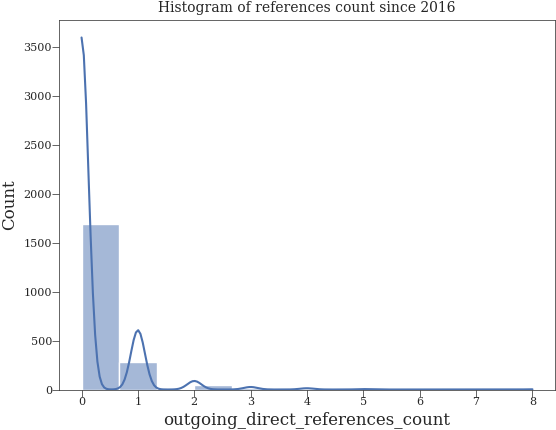

In [15]:
YEAR: int = 2016
modern_refs = df[df["year_from"] >= YEAR]
sns.histplot(modern_refs["outgoing_direct_references_count"], kde=True)

plt.title(f"Histogram of references count since {YEAR}")
plt.show()

#### Distribution of embodiments with assigned at least one CVE

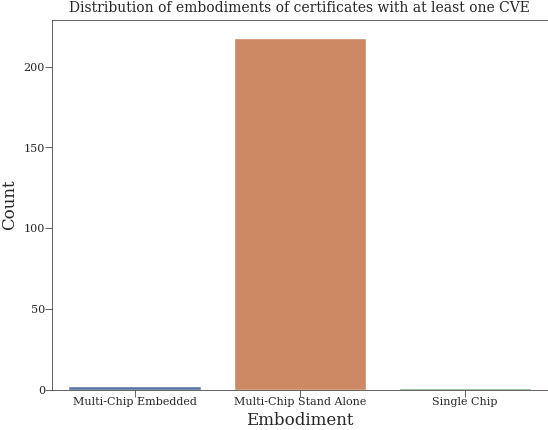

In [16]:
cve_df: DataFrame = df[df["related_cves"].notna()]
embodiments_counts = cve_df["embodiment"].value_counts()
sns.barplot(x=embodiments_counts.index, y=embodiments_counts.values)

plt.title("Distribution of embodiments of certificates with at least one CVE")
plt.xlabel("Embodiment")
plt.ylabel("Count")
plt.show()

#### Distribution of levels with assigned at least one CVE

In [17]:
def normalize_value_counts(df: DataFrame, series: Series, column: str) -> Series | None:
    """
    Function normalizes the value_counts in subdataset (e.g. cve_df)
    compared to the general dataset (e.g. df)
    """
    if column not in df.columns:
        return None

    data = []
    indices = []

    for tpl in series.items():
        index = tpl[0]
        count = tpl[1]
        amount_in_category = df[df[column] == index].shape[0]
        indices.append(index)
        data.append(round(count / amount_in_category, 3))

    return Series(index=indices, data=data)

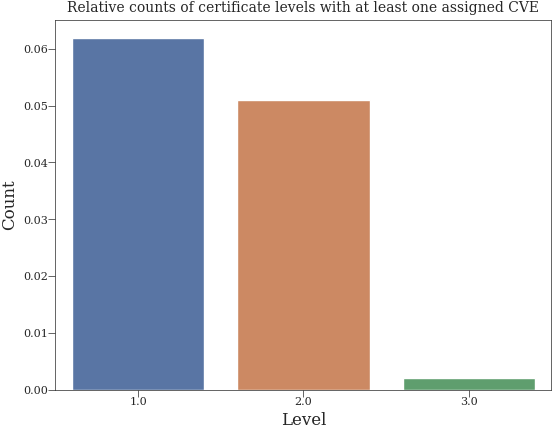

In [18]:
level_counts = cve_df["level"].value_counts()
normalized_level_counts = normalize_value_counts(df, level_counts, "level")

sns.barplot(x=normalized_level_counts.index, y=normalized_level_counts.values)

plt.title("Relative counts of certificate levels with at least one assigned CVE")
plt.xlabel("Level")
plt.ylabel("Count")
plt.show()

#### Distribution of types with assigned at least one CVE

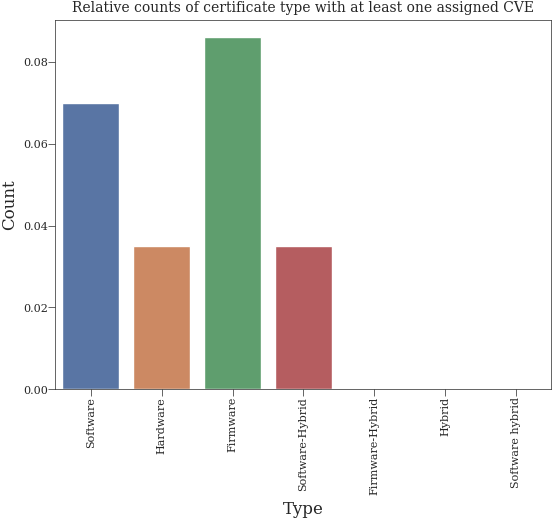

In [19]:
type_counts = cve_df["type"].value_counts()
normalized_type_counts = normalize_value_counts(df, type_counts, "type")

sns.barplot(x=normalized_type_counts.index, y=normalized_type_counts.values)

plt.title("Relative counts of certificate type with at least one assigned CVE")
plt.xlabel("Type")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

#### Distribution of statuses with assigned at least one CVE

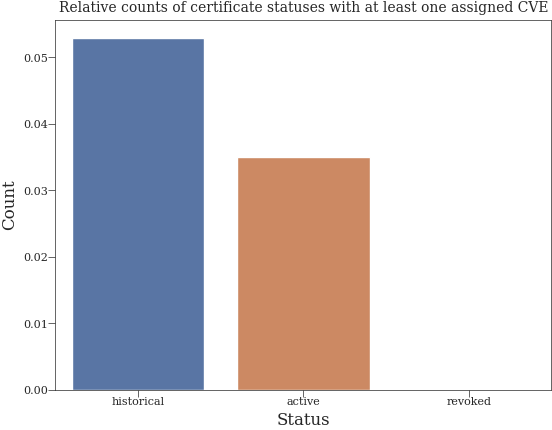

In [20]:
status_counts = cve_df["status"].value_counts()
normalized_status_counts = normalize_value_counts(df, status_counts, "status")

sns.barplot(x=normalized_status_counts.index, y=normalized_status_counts.values)

plt.title("Relative counts of certificate statuses with at least one assigned CVE")
plt.xlabel("Status")
plt.ylabel("Count")
plt.show()

### Statistics how many certificates are referenced and have at least one CVE assigned

In [21]:
cve_ref_df: DataFrame = df[(df["related_cves"].notna()) & (df["incoming_direct_references_count"] > 0)]
total_references: int = cve_ref_df["incoming_direct_references_count"].sum()

print(f"Total number of certificates which are referenced by at least one certificate and have assigned at least one assigned CVE: {total_references}")

Total number of certificates which are referenced by at least one certificate and have assigned at least one assigned CVE: 81


#### Potential vulnerable certificates 

In [22]:
# NOTE: List of certificates IDs which reference at least one certificate with assigned CVE
print(set.union(*cve_ref_df["module_directly_referenced_by"]))

{'4176', '2162', '2446', '1817', '4136', '4146', '1807', '1933', '979', '2721', '2633', '3880', '3563', '1337', '3891', '3469', '1791', '4135', '1386', '1805', '1385', '2212', '3421', '1002', '3168', '2605', '1808', '2742', '3892', '2404', '2798', '4206', '2908', '3286', '3348', '1806', '1053', '3733', '2604', '1792', '4147', '3921', '3699', '4145', '3007', '1500', '4266', '1384', '3893', '2997', '2447', '1859', '3939', '2915', '2343', '2630', '4164', '4148', '3306', '2582', '1001', '3170', '1338', '2736', '3342', '1445', '1449', '1339', '1003'}


#### The certificate with at least one CVE assigned and maximum of references from other certs

In [23]:
maximum_references: int = cve_ref_df["incoming_direct_references_count"].max()
print(f"Maximum amount of references from the other certificates referencing the vulnerable certificate: {maximum_references}")

Maximum amount of references from the other certificates referencing the vulnerable certificate: 7


In [24]:
cve_ref_df[cve_ref_df["incoming_direct_references_count"] == maximum_references]

,cert_id,status,standard,type,level,embodiment,year_from,related_cves,module_directly_referenced_by,module_indirectly_referenced_by,module_directly_referencing,module_indirectly_referencing,policy_directly_referenced_by,policy_indirectly_referenced_by,policy_directly_referencing,policy_indirectly_referencing,outgoing_direct_references_count,incoming_direct_references_count,outgoing_indirect_references_count,incoming_indirect_references_count
dgst,,,,,,,,,,,,,,,,,,,,
10acb87b3040f4e1,3616,historical,FIPS 140-2,Software,1.0,Multi-Chip Stand Alone,2020,"{CVE-2016-1908, CVE-2016-2801, CVE-2016-5404, ...","{3893, 4164, 4147, 3921, 4146, 4135, 3699}","{3893, 4164, 4147, 3921, 4146, 4135, 3699}",NaN,NaN,"{3699, 3893, 3921}","{3699, 3893, 3921}",NaN,NaN,0,7,0,7
3c4ee858b268931a,1336,historical,FIPS 140-2,Software,1.0,Multi-Chip Stand Alone,2010,"{CVE-2008-2250, CVE-2009-1216, CVE-2009-2526, ...","{2736, 1339, 1808, 1807, 1817, 1805, 1806}","{2736, 1339, 1808, 1807, 1817, 1805, 1806}",{1334},"{1333, 1334, 1321}","{1339, 1808, 1807, 1817, 1805, 1806}","{1339, 1808, 1807, 1817, 1805, 1806}",{1334},"{1333, 1334, 1321}",1,7,3,7


### Active certificates which reference at least one historical cert

In [25]:
active_certs_referencing_historical: list[int] = []
# NOTE: "cert_id" field is represented as integer, however "module_directly_referencing" is set of strings
historical_cert_ids: set[str] = set(df[df["status"] == "historical"]["cert_id"].apply(str))
active_referencing_certs: DataFrame = df[(df["status"] == "active") & (df["outgoing_direct_references_count"] > 0)]

for _, rows in active_referencing_certs.iterrows():
    referencing_ids = rows["module_directly_referencing"]
    intersection = referencing_ids & historical_cert_ids

    if intersection:
        active_certs_referencing_historical.append(rows.cert_id)

print(f"Total active certificates referencing at least one historical: {len(active_certs_referencing_historical)}")
print(f"Total active certificates referencing at least one certificate: {len(active_referencing_certs)}")

Total active certificates referencing at least one historical: 13
Total active certificates referencing at least one certificate: 131


#### Active certificate referencing at least one historical certificate with assigned CVE

In [26]:
active_cert_referencing_historical_with_cves: list[tuple[int, int]] = []

for _, cert in df[df["cert_id"].isin(active_certs_referencing_historical)].iterrows():
    cert_id = cert["cert_id"]

    for referenced_cert_id in cert["module_directly_referencing"]:
        referenced_cert_id_int = int(referenced_cert_id)
        related_cves = get_cert_property(df, referenced_cert_id_int, "related_cves")

        if not pd.isna(related_cves):
            print(f"Active certificate {cert_id} is referencing historical certificate {referenced_cert_id} with assigned CVE")
            active_cert_referencing_historical_with_cves.append((cert_id, referenced_cert_id_int))

active_cert_referencing_historical_with_cves

Active certificate 3939 is referencing historical certificate 3860 with assigned CVE


[(3939, 3860)]

### Certificates with higher levels referencing certificates with lower levels

In [27]:
referencing_certs: DataFrame = df[df["outgoing_direct_references_count"] > 0]
cert_level_ids: dict[int, set[str]] = {}
unique_levels: list[int] = df["level"].apply(int).unique()

for level in df["level"].unique():
    level_cert_ids: set[str] = set(df[df["level"] == level]["cert_id"].apply(str))
    cert_level_ids[int(level)] = level_cert_ids

In [28]:
def get_cert_ids_referencing_lower_level_cert(level_referencing_certs_df: DataFrame, lower_cert_ids: set[str]) -> list[int]:
    cert_ids = []

    for _, cert in level_referencing_certs_df.iterrows():
        if cert["module_directly_referencing"] & lower_cert_ids:
            cert_ids.append(cert["cert_id"])

    return cert_ids

#### Level 2 referencing at least one certificate of level 1

In [29]:
LEVEL2: int = 2
below_level2_cert_ids: set[str] = cert_level_ids[1]
level2_ref_certs = referencing_certs[referencing_certs["level"] == LEVEL2]
level2_referencing_lower_level = get_cert_ids_referencing_lower_level_cert(level2_ref_certs, below_level2_cert_ids)

print(f"Total amount of certificates with level {LEVEL2} referencing at least one certificate: {level2_ref_certs.shape[0]}")
print(f"Total amount of certicates with reference at least one certificate with lower level: {len(level2_referencing_lower_level)}")

Total amount of certificates with level 2 referencing at least one certificate: 41
Total amount of certicates with reference at least one certificate with lower level: 16


#### Level 3 referencing at least one certificate of level 1 or 2

In [30]:
LEVEL3: int = 3
below_level3_cert_ids = below_level2_cert_ids | cert_level_ids[2]
level3_ref_certs = referencing_certs[referencing_certs["level"] == LEVEL3]
level3_referencing_lower_level = get_cert_ids_referencing_lower_level_cert(level3_ref_certs, below_level3_cert_ids)

print(f"Total amount of certificates with level {LEVEL3} referencing at least one certificate: {level3_ref_certs.shape[0]}")
print(f"Total amount of certicates with reference at least one certificate with lower level: {len(level3_referencing_lower_level)}")

Total amount of certificates with level 3 referencing at least one certificate: 27
Total amount of certicates with reference at least one certificate with lower level: 1


#### Level 4 referencing at least one certificate of level 1, 2 or 3

In [31]:
LEVEL4: int = 4
below_level4_cert_ids = below_level3_cert_ids | cert_level_ids[3]
level4_ref_certs = referencing_certs[referencing_certs["level"] == LEVEL4]
level4_referencing_lower_level = get_cert_ids_referencing_lower_level_cert(level4_ref_certs, below_level4_cert_ids)
print(f"Total amount of certificates with level {LEVEL4} referencing at least one certificate: {level4_ref_certs.shape[0]}")

Total amount of certificates with level 4 referencing at least one certificate: 0


### Distribution of references among embodiments

In [32]:
def get_embodiment_references(df: DataFrame, embodiment: str) -> dict[str, int]:
    result: dict[str, int] = {}
    sub_df = df[(df["embodiment"] == embodiment) & (df["outgoing_direct_references_count"] > 0)]

    for references in sub_df["module_directly_referencing"]:
        for cert_id in references:
            referenced_embodiment: str = get_cert_property(df, cert_id, "embodiment")
            result[referenced_embodiment] = result.get(referenced_embodiment, 0) + 1

    return result

In [33]:
final_embodiment_statistics: dict[str, dict[str, int]] = {}

for embodiment in df["embodiment"].unique():
    final_embodiment_statistics[embodiment] = get_embodiment_references(df, embodiment)

pprint(final_embodiment_statistics)

{'Multi-Chip Embedded': {'Multi-Chip Embedded': 13, 'Single Chip': 2},
 'Multi-Chip Stand Alone': {'Multi-Chip Embedded': 7,
                            'Multi-Chip Stand Alone': 548,
                            'Single Chip': 30},
 'Single Chip': {'Multi-Chip Embedded': 2,
                 'Multi-Chip Stand Alone': 1,
                 'Single Chip': 28}}


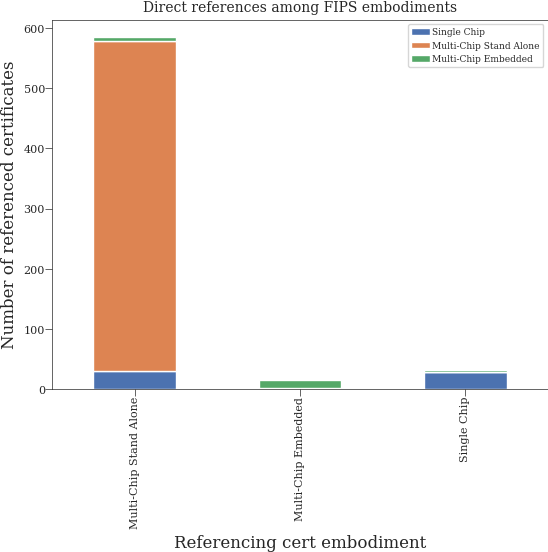

In [34]:
embodiment_df = pd.DataFrame(final_embodiment_statistics).fillna(0).astype(int).transpose()
embodiment_df.plot(kind="bar", stacked=True)

plt.xlabel("Referencing cert embodiment")
plt.ylabel("Number of referenced certificates")
plt.title("Direct references among FIPS embodiments")
plt.show()

### Distribution of references among types

In [35]:
def get_type_references(df: DataFrame, cert_type: str) -> dict[str, int]:
    result = {}
    sub_df = df[(df["type"] == cert_type) & (df["outgoing_direct_references_count"] > 0)]

    for references in sub_df["module_directly_referencing"]:
        for cert_id in references:
            referenced_type: str = get_cert_property(df, cert_id, "type")
            result[referenced_type] =result.get(referenced_type, 0) + 1

    return result

In [36]:
final_type_statistics: dict[str, dict[str, int]] = {}

for cert_type in df["type"].unique():
    final_type_statistics[cert_type] = get_type_references(df, cert_type)

pprint(final_type_statistics)

{'Firmware': {'Firmware': 1, 'Hardware': 1},
 'Firmware-Hybrid': {'Hardware': 2},
 'Hardware': {'Firmware': 2,
              'Firmware-Hybrid': 2,
              'Hardware': 78,
              'Software': 9},
 'Hybrid': {},
 'Software': {'Firmware': 1,
              'Hardware': 1,
              'Software': 504,
              'Software-Hybrid': 3},
 'Software hybrid': {},
 'Software-Hybrid': {'Hardware': 5, 'Software': 6, 'Software-Hybrid': 16}}


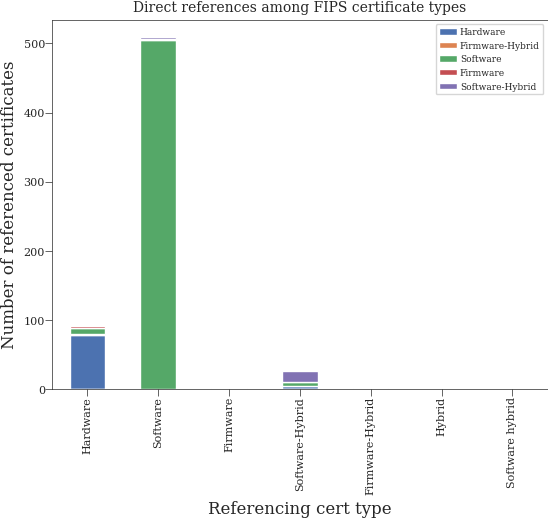

In [37]:
cert_type_df = pd.DataFrame(final_type_statistics).fillna(0).astype(int).transpose()
cert_type_df.plot(kind="bar", stacked=True)

plt.xlabel("Referencing cert type")
plt.ylabel("Number of referenced certificates")
plt.title("Direct references among FIPS certificate types")
plt.show()

### Temporal evolution of referencing certificates amount displayed in percentages per year

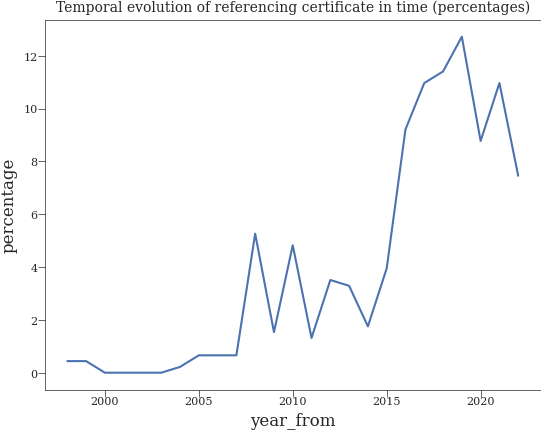

In [38]:
def convert_refences_count_to_relative(number: int, n_issued_certs: int) -> float:
    return 100 * number / n_issued_certs

THRESHOLD_YEAR: int = 2023

temporal_df: DataFrame = df[(df["outgoing_direct_references_count"] > 0) & (df["year_from"] < THRESHOLD_YEAR)]
total_referencing_certs: int = temporal_df.shape[0]
grouped_df: DataFrame = temporal_df.groupby("year_from")
converted_df: DataFrame = grouped_df.size().reset_index(name="year_references")

# Fill missing years
dataset_years: set[int] = set(converted_df["year_from"])
years_interval: set[int] = set(range(min(dataset_years), max(dataset_years) + 1))
missing_years: set[int] = years_interval - dataset_years

for year in missing_years:
    converted_df.loc[len(converted_df.index)] = (year, 0)

converted_df["percentage"] = converted_df["year_references"].apply(convert_refences_count_to_relative, args=(total_referencing_certs,))
line = sns.lineplot(data=converted_df, x="year_from", y="percentage")

plt.title("Temporal evolution of referencing certificate in time (percentages)")
plt.show()

### Cross-references among certificates

Certificate A directly references certificate B and at the same time certificate B directly references certificate A.
In other words intersection of `module_directly_referenced_by` and `module_directly_referencing` results into discovery of cross references in the dataset.

In [39]:
result: list[tuple[int, int]] = []
cross_references_df: DataFrame = df[(df["incoming_direct_references_count"] > 0) & (df["outgoing_direct_references_count"] > 0)]


for _, cert in cross_references_df.iterrows():
    referenced_by = cert["module_directly_referenced_by"]
    referencing = cert["module_directly_referencing"]
    cert_id = cert["cert_id"]

    intersection: set[str] = referenced_by & referencing


    for another_cert_id in intersection:
        another_cert_id_int = int(another_cert_id)

        if not (another_cert_id_int, cert_id) in result:
            result.append((cert_id, int(another_cert_id)))

print(result)

[(3384, 3382), (3382, 3383), (63, 80)]


In [40]:
df[df["cert_id"].isin([3382, 3383, 3384])]

,cert_id,status,standard,type,level,embodiment,year_from,related_cves,module_directly_referenced_by,module_indirectly_referenced_by,module_directly_referencing,module_indirectly_referencing,policy_directly_referenced_by,policy_indirectly_referenced_by,policy_directly_referencing,policy_indirectly_referencing,outgoing_direct_references_count,incoming_direct_references_count,outgoing_indirect_references_count,incoming_indirect_references_count
dgst,,,,,,,,,,,,,,,,,,,,
6ef02a389c6415e7,3384,active,FIPS 140-2,Hardware,1.0,Multi-Chip Embedded,2019,NaN,{3382},"{3382, 3384, 3383}",{3382},"{3382, 3384, 3383}",{3382},"{3382, 3384, 3383}",{3382},"{3382, 3384, 3383}",1,1,3,3
a080dde530fce451,3382,active,FIPS 140-2,Hardware,1.0,Single Chip,2019,NaN,"{3384, 3383}","{3382, 3384, 3383}","{3384, 3383}","{3382, 3384, 3383}","{3384, 3383}","{3382, 3384, 3383}","{3384, 3383}","{3382, 3384, 3383}",2,2,3,3
efb092e03612f568,3383,active,FIPS 140-2,Hardware,1.0,Multi-Chip Embedded,2019,NaN,{3382},"{3382, 3384, 3383}",{3382},"{3382, 3384, 3383}",{3382},"{3382, 3384, 3383}",{3382},"{3382, 3384, 3383}",1,1,3,3


### Referenced certs, which are not referencing any other cert

In [41]:
not_referencing_df: DataFrame = df[(df["outgoing_direct_references_count"] == 0) & (df["incoming_direct_references_count"] > 0)]
print(f"In the dataset is total of {not_referencing_df.shape[0]} certificates which are referenced by at least one cert and not referencing any other certs.")

In the dataset is total of 151 certificates which are referenced by at least one cert and not referencing any other certs.


#### Status of the certificates

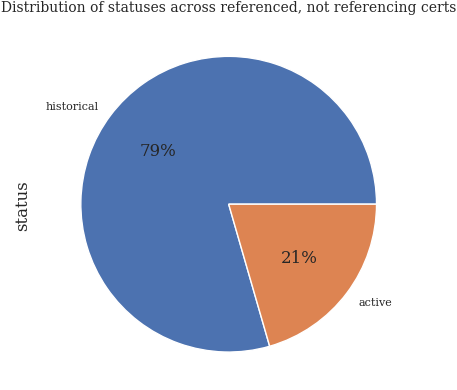

In [42]:
not_referencing_df["status"].value_counts().loc[lambda x: x > 0].plot.pie(autopct="%.0f%%")

plt.title("Distribution of statuses across referenced, not referencing certs")
plt.show()

#### Histogram of most common CVEs of certificates which are not referencing any other certificate and are referenced by at least one 

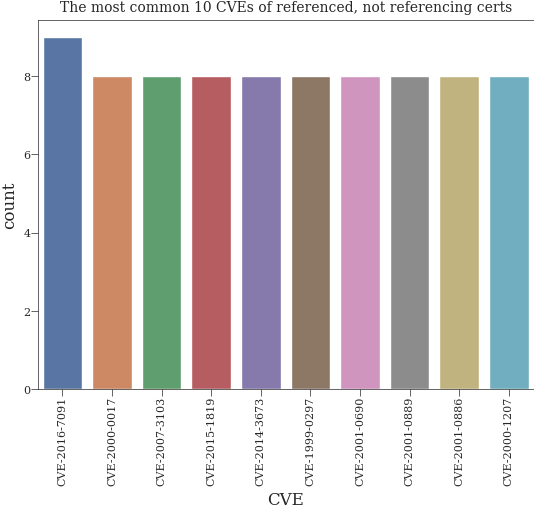

In [43]:
number_of_cves: int = 10
counter: Counter = Counter()

for cve_set in not_referencing_df["related_cves"]:
    if pd.isna(cve_set):
        continue
    counter.update(cve_set)

not_referencing_cve_df: DataFrame = pd.DataFrame.from_dict(counter, orient="index").reset_index()
not_referencing_cve_df.columns = ("CVE", "count")
not_referencing_cve_df.sort_values(by="count", ascending=False, inplace=True)
sns.barplot(x="CVE", y="count", data=not_referencing_cve_df.head(number_of_cves))

plt.title(f"The most common {number_of_cves} CVEs of referenced, not referencing certs")
plt.xticks(rotation=90)
plt.show()

### Certificates which are referenced, but not referencing any other certificate

In [44]:
not_referenced_df: DataFrame = df[(df["outgoing_direct_references_count"] > 0) & (df["incoming_direct_references_count"] == 0)]
print(f"There are total of {not_referenced_df.shape[0]} certs, which are referencing at least one other cert and referenced by no other cert")

There are total of 380 certs, which are referencing at least one other cert and referenced by no other cert


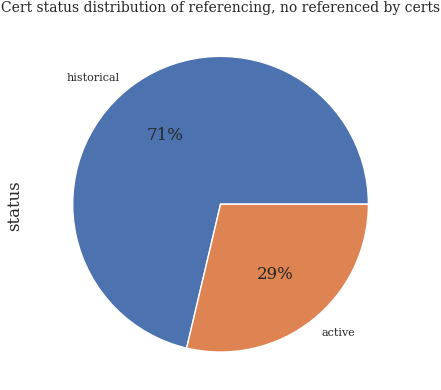

In [45]:
not_referenced_df["status"].value_counts().loc[lambda x: x > 0].plot.pie(autopct="%.0f%%")

plt.title("Cert status distribution of referencing, no referenced by certs")
plt.show()

#### Histogram of most common CVEs of certificates which are referencing at least one other certicate and are not referenced by any other one

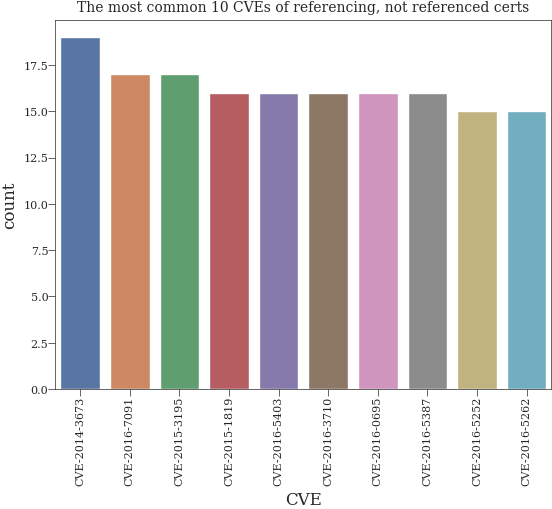

In [46]:
number_of_cves: int = 10
counter: Counter = Counter()
cve_rich_certs_df: DataFrame = not_referenced_df[not_referenced_df["related_cves"].notna()]

for cve_set in cve_rich_certs_df["related_cves"]:
    counter.update(cve_set)

not_referenced_by_df: DataFrame = pd.DataFrame.from_dict(counter, orient="index").reset_index()
not_referenced_by_df.columns = ("CVE", "count")
not_referenced_by_df.sort_values(by="count", ascending=False, inplace=True)

sns.barplot(x="CVE", y="count", data=not_referenced_by_df.head(number_of_cves))

plt.title(f"The most common {number_of_cves} CVEs of referencing, not referenced certs")
plt.xticks(rotation=90)
plt.show()

### Certificate overview

In [47]:
COLOUR_MAPPING = {
    "chosen_cert_colour": "lightgreen",
    "referencing_colour": "lightblue",
    "referenced_colour": "red",
}

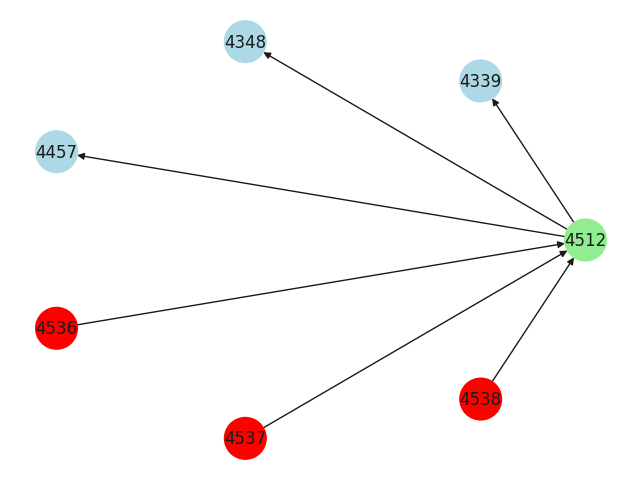

In [48]:
cert_id: int = 4512 # Enter the certificate ID you are interested in

graph, node_colors = get_fips_cert_references_graph(df, cert_id, COLOUR_MAPPING)
pos = nx.circular_layout(graph)
nx.draw(graph, pos, arrows=True, node_color=node_colors, with_labels=True, node_size=900)

In [49]:
cert_id_series = df[df["cert_id"] == cert_id]
cert_dgst = cert_id_series.index[0]

print(f"Certificate ID: {cert_id}:")
print(f" - references the certificates {cert_id_series['module_directly_referencing']}")
print(f" - is referenced by certificates {cert_id_series['module_directly_referenced_by']}")
print(f" - its page is at https://seccerts.org/fips/{cert_dgst}/")

Certificate ID: 4512:
 - references the certificates dgst
033581b0970477af    {4339, 4348, 4457}
Name: module_directly_referencing, dtype: object
 - is referenced by certificates dgst
033581b0970477af    {4536, 4537, 4538}
Name: module_directly_referenced_by, dtype: object
 - its page is at https://seccerts.org/fips/033581b0970477af/


### Graph of the most referenced certificate

In [50]:
STATUS_TO_COLOUR_MAPPING: dict[str, str] = {
    "active": "lightblue",
    "historical": "red",
    "revoked": "blue",
}

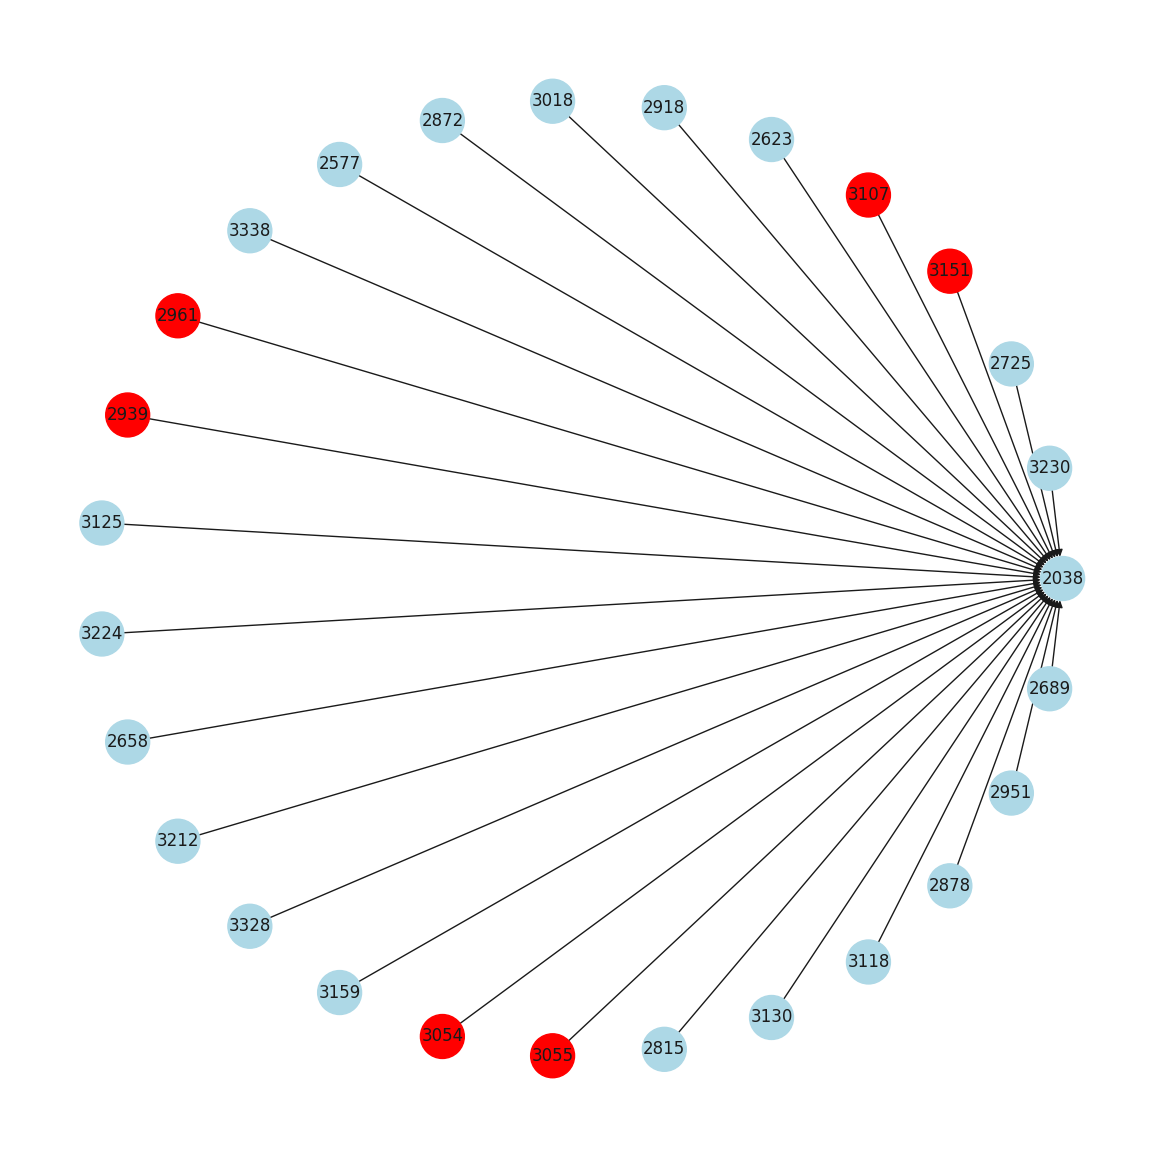

In [51]:
graph, node_colors = get_most_referenced_cert_graph(df, STATUS_TO_COLOUR_MAPPING)
fig, ax = plt.subplots(figsize=(15, 15))
pos = nx.circular_layout(graph)
nx.draw(graph, pos, node_color=node_colors, arrows=True, with_labels=True, node_size=1000)
plt.show()

### Graph of the most referencing certitificate

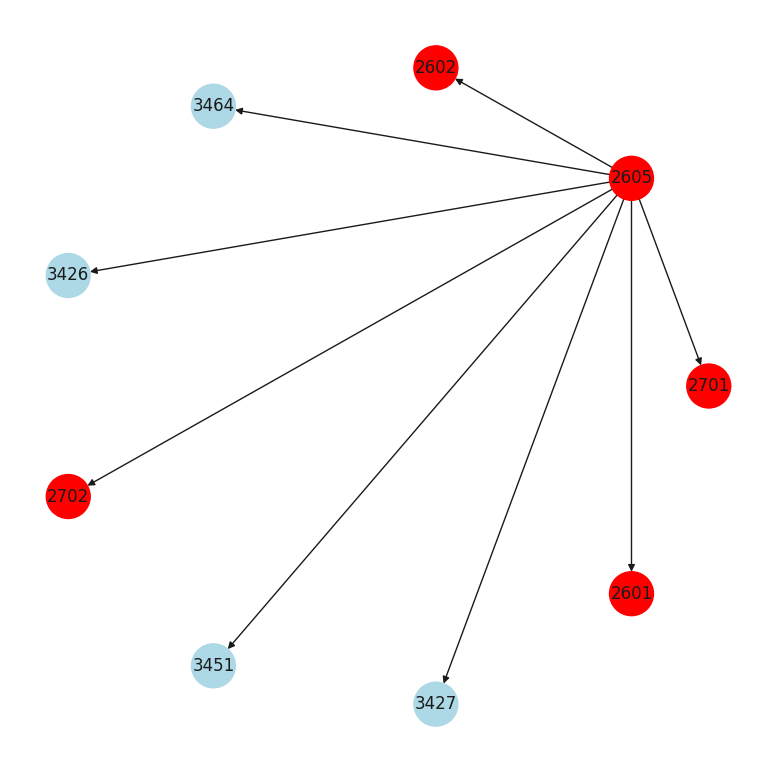

In [52]:
graph, node_colors = get_most_referencing_cert_graph(df, STATUS_TO_COLOUR_MAPPING)
fig, ax = plt.subplots(figsize=(10, 10))
pos = nx.circular_layout(graph)
nx.draw(graph, pos, node_color=node_colors, arrows=True, with_labels=True, node_size=1000)
plt.show()